# Hypothesis generation step: Mordred featurization + RFE + random forest regression + Shapley value analysis

Ver 1, 20210921

For the hypothesis generation step, we have put together: Mordred featurization, recursive feature elimination (RFE), random forest regression, and Shapley value analysis.

## Loading dataset

Choose which dataset you want for your first or second round of your hypothesis generation.

In [1]:
# Import all the packages needed for the notebook to run

# %matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import rdkit
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv
from IPython.display import display_html
import seaborn as sns

In [2]:
# Import the perovskite crystal data
from collections import OrderedDict
cmaps = OrderedDict()

## IMPORTING DATA

# Change directory to where your .csv file is
os.chdir(os.getcwd())

# Load the .csv file 
# The molecular features & processing conditions are loaded as X and y

# CHOOSE ROUND 1 OR ROUND 2
complete_Xy = pd.read_csv('dataset/20211006_round2_compiledData.csv') # round 2
# complete_Xy = pd.read_csv('dataset/20210923_round1_compiledData.csv') # round 1

# Check if the data is loaded and separated correctly
pd.set_option('max_rows', 8)
complete_Xy

,SMILES,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),Reagent5 (ul),Reagent6 (ul),Reagent7 (ul),Reagent8 (ul),Reagent9 (ul),crystal_score,crystal_size,lab_code
0,Cc1cccc(n1)-c2cccc(C)n2,28,126,4,41,0,0,0,0,800,4.0,1.4593,1
1,Cc1cccc(n1)-c2cccc(C)n2,100,6,41,52,0,0,0,0,800,1.0,0.0000,1
2,Cc1cccc(n1)-c2cccc(C)n2,14,88,18,80,0,0,0,0,800,4.0,0.7670,1
3,Cc1cccc(n1)-c2cccc(C)n2,28,69,83,20,0,0,0,0,800,4.0,0.7070,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,3,46,95,56,0,0,0,0,800,1.0,0.0000,1
309,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,57,88,36,19,0,0,0,0,800,1.0,0.0000,1
310,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,125,28,23,24,0,0,0,0,800,1.0,0.0000,1
311,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,54,28,62,55,0,0,0,0,800,1.0,0.0000,1


In [3]:
# Read the dataframe of degradation data
data_Xy = pd.DataFrame(complete_Xy)

# Only use the one with additives
data_noAdditive = data_Xy[data_Xy['SMILES']!= 'no_additive']

# Clean the NaN on crystal score
data_noAdditive = data_noAdditive.dropna(subset=['crystal_score','crystal_size'])

# Separate the X without SMILES (excluding the y)
# X_withoutSMILES = data_Xy.drop(['crystal_score','avg_surface_area','SMILES'],axis=1)
X_withoutSMILES = data_noAdditive.drop(['crystal_score','crystal_size','SMILES'],axis=1)

# Separate the X with SMILES (excluding the y)
# X_withSMILES = data_Xy.drop(['crystal_score','avg_surface_area'],axis=1)
X_withSMILES = data_noAdditive.drop(['crystal_score','crystal_size'],axis=1)
X_withSMILES


,SMILES,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),Reagent5 (ul),Reagent6 (ul),Reagent7 (ul),Reagent8 (ul),Reagent9 (ul),lab_code
0,Cc1cccc(n1)-c2cccc(C)n2,28,126,4,41,0,0,0,0,800,1
1,Cc1cccc(n1)-c2cccc(C)n2,100,6,41,52,0,0,0,0,800,1
2,Cc1cccc(n1)-c2cccc(C)n2,14,88,18,80,0,0,0,0,800,1
3,Cc1cccc(n1)-c2cccc(C)n2,28,69,83,20,0,0,0,0,800,1
...,...,...,...,...,...,...,...,...,...,...,...
308,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,3,46,95,56,0,0,0,0,800,1
309,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,57,88,36,19,0,0,0,0,800,1
310,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,125,28,23,24,0,0,0,0,800,1
311,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,54,28,62,55,0,0,0,0,800,1


In [4]:
# Assign the crystal size as y
y = data_noAdditive['crystal_size']
y

0      1.4593
1      0.0000
2      0.7670
3      0.7070
        ...  
308    0.0000
309    0.0000
310    0.0000
311    0.0000
Name: crystal_size, Length: 264, dtype: float64

## Featurization

Now, we are doing featurization to convert the SMILES from our dataset to Mordred descriptors/ features.

### Using RDkit to generate ROMol

In [5]:
# Indicate where the SMILES is for the ROMol generation
esol_data = X_withSMILES['SMILES']
# esol_data

In [6]:
# Import RDkit packages
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from rdkit.Chem import PandasTools

,SMILES,ROMol
0,Cc1cccc(n1)-c2cccc(C)n2,
1,Cc1cccc(n1)-c2cccc(C)n2,
2,Cc1cccc(n1)-c2cccc(C)n2,
3,Cc1cccc(n1)-c2cccc(C)n2,
4,Cc1cccc(n1)-c2cccc(C)n2,

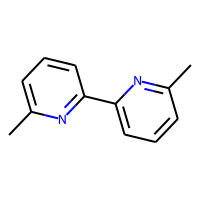
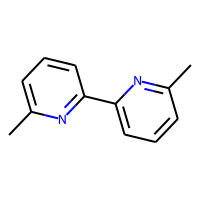
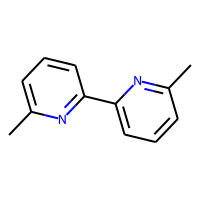
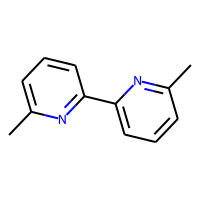
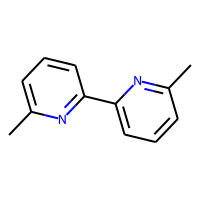

In [7]:
from rdkit.Chem import AllChem

# Generate ROMol
esol_data = pd.DataFrame(X_withSMILES['SMILES'])
PandasTools.AddMoleculeColumnToFrame(esol_data, smilesCol='SMILES')
esol_data.head(5)

### Incorporating Modred features

You can read more on Mordred descriptors here: 
1. Moriwaki, H., Tian, YS., Kawashita, N. et al. Mordred: a molecular descriptor calculator. J Cheminform 10, 4 (2018). https://doi.org/10.1186/s13321-018-0258-y
2. Mordred descriptors GitHub package: https://github.com/mordred-descriptor/mordred/blob/develop/examples/030-multiple_mol-multiple_desc.py

In [8]:
# Import more packages
from multiprocessing import freeze_support
from rdkit import Chem
from mordred import Calculator, descriptors

In [9]:
from rdkit import Chem

# Find the unique SMILES, and put them in a list
smiles_unique =((esol_data['SMILES'].unique()).tolist())
smiles_list = []
for i in range(len(smiles_unique)):
    smiles_list.append(Chem.MolFromSmiles(smiles_unique[i]))

In [10]:
# Create Calculator, and calculate the Mordred descriptors into dataframe for unique SMILES
calc = Calculator(descriptors)
calc.pandas(smiles_list)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.83it/s]


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,10.784941,9.210281,0,0,17.820064,2.325836,4.651672,17.820064,1.272862,3.564437,...,9.364862,45.452411,184.100048,7.080771,301,18,70.0,79.0,4.444444,3.111111
1,10.784941,8.989080,0,0,18.121287,2.316265,4.632531,18.121287,1.294378,3.564424,...,9.347577,45.428250,184.100048,7.080771,315,18,70.0,79.0,4.444444,3.111111
2,9.151948,7.830014,0,0,16.383377,2.278414,4.556827,16.383377,1.365281,3.412246,...,9.076466,42.338794,156.068748,7.803437,198,14,58.0,65.0,2.722222,2.777778
3,15.639095,13.259246,0,0,23.959451,2.404364,4.808728,23.959451,1.197973,3.918339,...,9.985206,53.910674,268.193949,6.095317,808,30,106.0,121.0,8.569444,4.111111
4,10.704061,9.431481,0,0,18.151011,2.363435,4.726869,18.151011,1.296501,3.565020,...,9.463509,45.635243,188.058577,8.548117,287,20,70.0,81.0,4.444444,3.166667
5,14.877752,11.849989,0,0,25.481780,2.383554,4.767108,25.481780,1.341146,3.880811,...,9.752839,52.218569,249.090212,8.303007,702,27,98.0,113.0,4.805556,4.222222
6,11.980375,10.246883,0,0,21.229776,2.339451,4.678903,21.229776,1.326861,3.686337,...,9.470780,47.986282,216.089878,7.717496,448,22,78.0,89.0,4.944444,3.777778
7,23.791976,19.094269,0,0,36.129301,2.457256,4.914512,36.129301,1.204310,4.330018,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556


### Add Mordred features into dataframe

Now let's add Mordred into actual dataframe (not only the unique SMILES).

,SMILES,ROMol
0,Cc1cccc(n1)-c2cccc(C)n2,
1,Cc1cccc(n1)-c2cccc(C)n2,
2,Cc1cccc(n1)-c2cccc(C)n2,
3,Cc1cccc(n1)-c2cccc(C)n2,
...,...,...
308,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,
309,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,
310,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,
311,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,

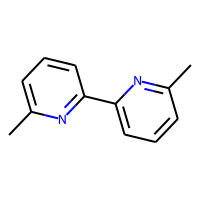
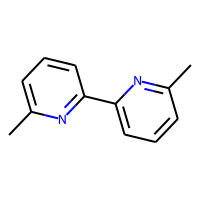
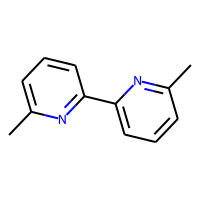
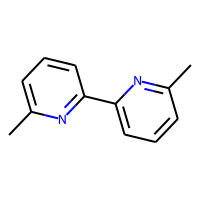
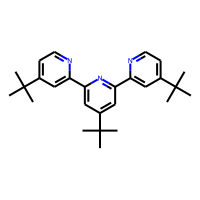
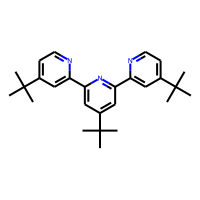
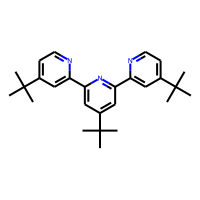
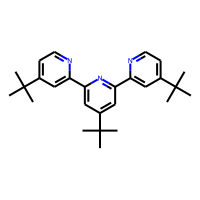

In [11]:
esol_data = pd.DataFrame(X_withSMILES['SMILES'])
PandasTools.AddMoleculeColumnToFrame(esol_data, smilesCol='SMILES')
esol_data

In [12]:
# Generate the Mordred descriptors for the whole dataset
mordred_data = calc.pandas(esol_data['ROMol'])
mordred_data = mordred_data.dropna(axis='columns')
mordred_data.to_csv('test_mordred.csv',index = False, header=True)
mordred_data
mordred_data.dtypes

100%|████████████████████████████████████████████████████████████████████████████████| 264/264 [00:13<00:00, 19.44it/s]


ABC         float64
ABCGG       float64
nAcid         int64
nBase         int64
             ...   
Zagreb1     float64
Zagreb2     float64
mZagreb1    float64
mZagreb2    float64
Length: 1826, dtype: object

In [13]:
# Exclude data with 'number' dtype
numeric_cols = mordred_data.select_dtypes(exclude='number')
mordred_data.drop(numeric_cols, axis=1, inplace=True)
mordred_data

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,10.784941,9.210281,0,0,17.820064,2.325836,4.651672,17.820064,1.272862,3.564437,...,9.364862,45.452411,184.100048,7.080771,301,18,70.0,79.0,4.444444,3.111111
1,10.784941,9.210281,0,0,17.820064,2.325836,4.651672,17.820064,1.272862,3.564437,...,9.364862,45.452411,184.100048,7.080771,301,18,70.0,79.0,4.444444,3.111111
2,10.784941,9.210281,0,0,17.820064,2.325836,4.651672,17.820064,1.272862,3.564437,...,9.364862,45.452411,184.100048,7.080771,301,18,70.0,79.0,4.444444,3.111111
3,10.784941,9.210281,0,0,17.820064,2.325836,4.651672,17.820064,1.272862,3.564437,...,9.364862,45.452411,184.100048,7.080771,301,18,70.0,79.0,4.444444,3.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,23.791976,19.094269,0,0,36.129301,2.457256,4.914512,36.129301,1.204310,4.330018,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556
309,23.791976,19.094269,0,0,36.129301,2.457256,4.914512,36.129301,1.204310,4.330018,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556
310,23.791976,19.094269,0,0,36.129301,2.457256,4.914512,36.129301,1.204310,4.330018,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556
311,23.791976,19.094269,0,0,36.129301,2.457256,4.914512,36.129301,1.204310,4.330018,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556


In [14]:
# Check dtypes
mordred_data.dtypes

ABC         float64
ABCGG       float64
nAcid         int64
nBase         int64
             ...   
Zagreb1     float64
Zagreb2     float64
mZagreb1    float64
mZagreb2    float64
Length: 1430, dtype: object

In [15]:
# Combined the X collected from the experiment with Mordred descriptors 
X_combined = X_withoutSMILES.join(mordred_data)
X_combined

,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),Reagent5 (ul),Reagent6 (ul),Reagent7 (ul),Reagent8 (ul),Reagent9 (ul),lab_code,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,28,126,4,41,0,0,0,0,800,1,...,9.364862,45.452411,184.100048,7.080771,301,18,70.0,79.0,4.444444,3.111111
1,100,6,41,52,0,0,0,0,800,1,...,9.364862,45.452411,184.100048,7.080771,301,18,70.0,79.0,4.444444,3.111111
2,14,88,18,80,0,0,0,0,800,1,...,9.364862,45.452411,184.100048,7.080771,301,18,70.0,79.0,4.444444,3.111111
3,28,69,83,20,0,0,0,0,800,1,...,9.364862,45.452411,184.100048,7.080771,301,18,70.0,79.0,4.444444,3.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,3,46,95,56,0,0,0,0,800,1,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556
309,57,88,36,19,0,0,0,0,800,1,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556
310,125,28,23,24,0,0,0,0,800,1,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556
311,54,28,62,55,0,0,0,0,800,1,...,10.468943,66.167879,401.283098,6.173586,2382,49,164.0,190.0,12.715278,6.055556


### Sanity check with the dissimilarity matrix

Done on the first 100 columns because the float64 dtype is infinite.

In [16]:
# Select the first 100 columns because dtype can't handle too much data
print(X_combined.isnull().values.any()) # Check if there is null
subselected_X = X_combined.iloc[: , :100]
subselected_X

False


,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),Reagent5 (ul),Reagent6 (ul),Reagent7 (ul),Reagent8 (ul),Reagent9 (ul),lab_code,...,ATS0v,ATS1v,ATS2v,ATS3v,ATS4v,ATS5v,ATS6v,ATS7v,ATS8v,ATS0se
0,28,126,4,41,0,0,0,0,800,1,...,5941.836101,7319.566840,9902.047431,10092.331242,8639.950757,7587.900859,6168.320431,4268.553634,2084.455817,191.511032
1,100,6,41,52,0,0,0,0,800,1,...,5941.836101,7319.566840,9902.047431,10092.331242,8639.950757,7587.900859,6168.320431,4268.553634,2084.455817,191.511032
2,14,88,18,80,0,0,0,0,800,1,...,5941.836101,7319.566840,9902.047431,10092.331242,8639.950757,7587.900859,6168.320431,4268.553634,2084.455817,191.511032
3,28,69,83,20,0,0,0,0,800,1,...,5941.836101,7319.566840,9902.047431,10092.331242,8639.950757,7587.900859,6168.320431,4268.553634,2084.455817,191.511032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,3,46,95,56,0,0,0,0,800,1,...,13252.829922,16953.283305,25868.174602,31846.739876,31409.927226,29272.003432,28226.920861,28996.910666,29549.124112,469.345080
309,57,88,36,19,0,0,0,0,800,1,...,13252.829922,16953.283305,25868.174602,31846.739876,31409.927226,29272.003432,28226.920861,28996.910666,29549.124112,469.345080
310,125,28,23,24,0,0,0,0,800,1,...,13252.829922,16953.283305,25868.174602,31846.739876,31409.927226,29272.003432,28226.920861,28996.910666,29549.124112,469.345080
311,54,28,62,55,0,0,0,0,800,1,...,13252.829922,16953.283305,25868.174602,31846.739876,31409.927226,29272.003432,28226.920861,28996.910666,29549.124112,469.345080


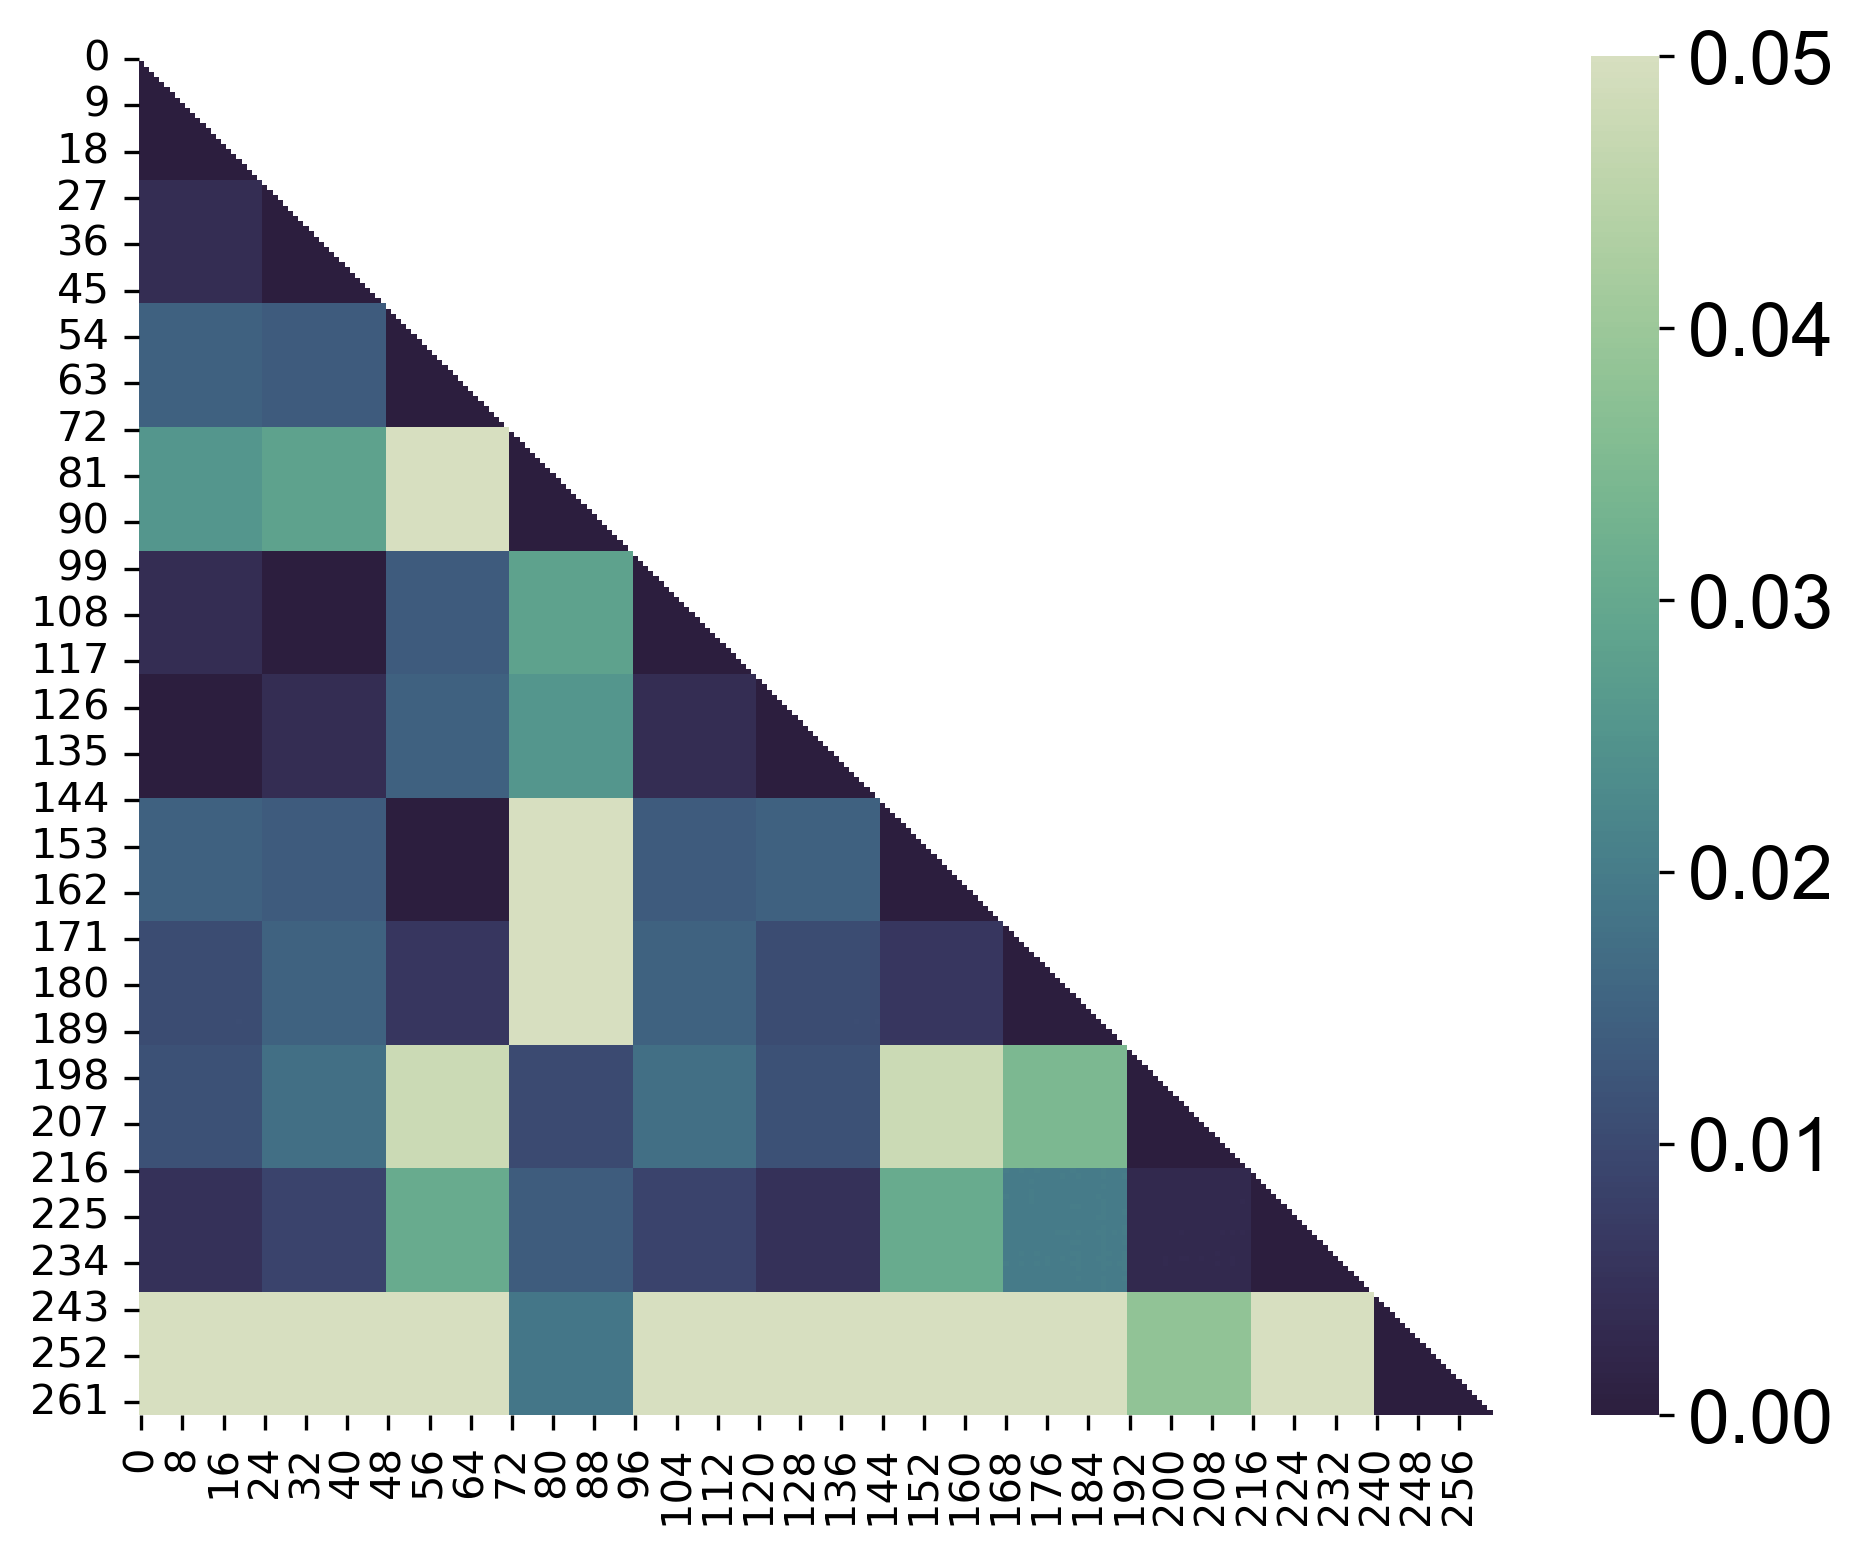

In [17]:
# Check the dissimilarity matrix of the dataset 

from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns

metric = 'cosine'

if metric=="cosine":
    cmap = sns.cubehelix_palette(start=.5, rot=-.75, reverse=True, as_cmap=True) # colormap for cosine
    colorMax = 0.05
    colorMin = 0
elif metric=="euclidean":
    cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
    colorMax = 1000
    colorMin = 0
else:
    cmap = sns.cubehelix_palette(start=2, rot=.25, reverse=True, as_cmap=True)
    colorMax = 30000
    colorMin = 0

d_absorber = pairwise_distances(subselected_X, metric=metric) # Calculating the pairwise distance

# Masking upper triangle
mask_ut = np.triu(np.ones_like(d_absorber,dtype=bool))    

# Visualizing dissimilarity matrix

# Specify where to save the image
# os.chdir(currentDir+'/Results/'+folderToSave+'/bare_cap9_PTEAI/')

# Plot the dissimilarity matrix
fig = plt.figure(1,figsize=(8,6),dpi=300) # for all use 10,10; 8,6 for subsets
ax = fig.add_subplot(111)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18 # for all: 20, 24 for subsets

ax = sns.heatmap(d_absorber, mask=mask_ut, cmap=cmap, vmax=colorMax,
            vmin=colorMin, square=True)
plt.show()

## Recursive feature elimination

Now, we are starting to pick the features from our dataset.

### Excluding highly correlated features (> 95%)

In [18]:
# Import all the packages needed
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [19]:
# Assign y binary as y for classification
y_binary = y

In [20]:
# Check the correlation matrix, to drop highly correlated features (above 0.95)
cor_matrix = X_combined.corr().abs()
cor_matrix

,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),Reagent5 (ul),Reagent6 (ul),Reagent7 (ul),Reagent8 (ul),Reagent9 (ul),lab_code,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
Reagent1 (ul),1.000000,0.350653,0.361546,0.339056,NaN,NaN,NaN,NaN,NaN,0.010417,...,0.021459,0.034700,0.037514,0.042071,0.038321,0.032495,0.033200,0.032281,0.031846,0.044372
Reagent2 (ul),0.350653,1.000000,0.317254,0.361858,NaN,NaN,NaN,NaN,NaN,0.040935,...,0.046949,0.043264,0.042240,0.077672,0.044393,0.043287,0.046903,0.045700,0.058417,0.029934
Reagent3 (ul),0.361546,0.317254,1.000000,0.266803,NaN,NaN,NaN,NaN,NaN,0.042935,...,0.075267,0.086103,0.089472,0.143749,0.091902,0.084346,0.088068,0.085449,0.105148,0.083362
Reagent4 (ul),0.339056,0.361858,0.266803,1.000000,NaN,NaN,NaN,NaN,NaN,0.010474,...,0.002060,0.002630,0.004014,0.015491,0.003511,0.003221,0.002402,0.002061,0.008466,0.003584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zagreb1,0.033200,0.046903,0.088068,0.002402,NaN,NaN,NaN,NaN,NaN,0.178332,...,0.975475,0.998499,0.998316,0.564935,0.981354,0.997566,1.000000,0.999833,0.965985,0.988577
Zagreb2,0.032281,0.045700,0.085449,0.002061,NaN,NaN,NaN,NaN,NaN,0.187340,...,0.976261,0.998627,0.998514,0.551386,0.980960,0.998330,0.999833,1.000000,0.964002,0.989634
mZagreb1,0.031846,0.058417,0.105148,0.008466,NaN,NaN,NaN,NaN,NaN,0.080187,...,0.962387,0.963941,0.965588,0.703036,0.946353,0.967940,0.965985,0.964002,1.000000,0.933849
mZagreb2,0.044372,0.029934,0.083362,0.003584,NaN,NaN,NaN,NaN,NaN,0.246314,...,0.961703,0.991857,0.993744,0.480712,0.968514,0.990296,0.988577,0.989634,0.933849,1.000000


In [21]:
# Masking the upper triangle
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

# Find which columns are to drop
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

# Drop the columns with high correlation
X_all_pre_noCorr = X_combined.drop(to_drop, axis=1)
X_all_pre_noCorr

C:\Users\Titan\AppData\Local\Temp/ipykernel_12952/1914692928.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),Reagent5 (ul),Reagent6 (ul),Reagent7 (ul),Reagent8 (ul),Reagent9 (ul),lab_code,...,nRot,RotRatio,JGI2,JGI3,JGI6,JGI8,SRW03,SRW05,SRW07,SRW09
0,28,126,4,41,0,0,0,0,800,1,...,1,0.066667,0.066667,0.041667,0.020408,0.000000,0.0,0.0,0.0,0.0
1,100,6,41,52,0,0,0,0,800,1,...,1,0.066667,0.066667,0.041667,0.020408,0.000000,0.0,0.0,0.0,0.0
2,14,88,18,80,0,0,0,0,800,1,...,1,0.066667,0.066667,0.041667,0.020408,0.000000,0.0,0.0,0.0,0.0
3,28,69,83,20,0,0,0,0,800,1,...,1,0.066667,0.066667,0.041667,0.020408,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,3,46,95,56,0,0,0,0,800,1,...,2,0.062500,0.093333,0.044643,0.016224,0.023648,0.0,0.0,0.0,0.0
309,57,88,36,19,0,0,0,0,800,1,...,2,0.062500,0.093333,0.044643,0.016224,0.023648,0.0,0.0,0.0,0.0
310,125,28,23,24,0,0,0,0,800,1,...,2,0.062500,0.093333,0.044643,0.016224,0.023648,0.0,0.0,0.0,0.0
311,54,28,62,55,0,0,0,0,800,1,...,2,0.062500,0.093333,0.044643,0.016224,0.023648,0.0,0.0,0.0,0.0


### Recursive Feature Elimination (RFE)

>4 -0.258 (0.098)
>8 -0.225 (0.083)
>12 -0.226 (0.079)
>16 -0.222 (0.085)
>20 -0.223 (0.081)


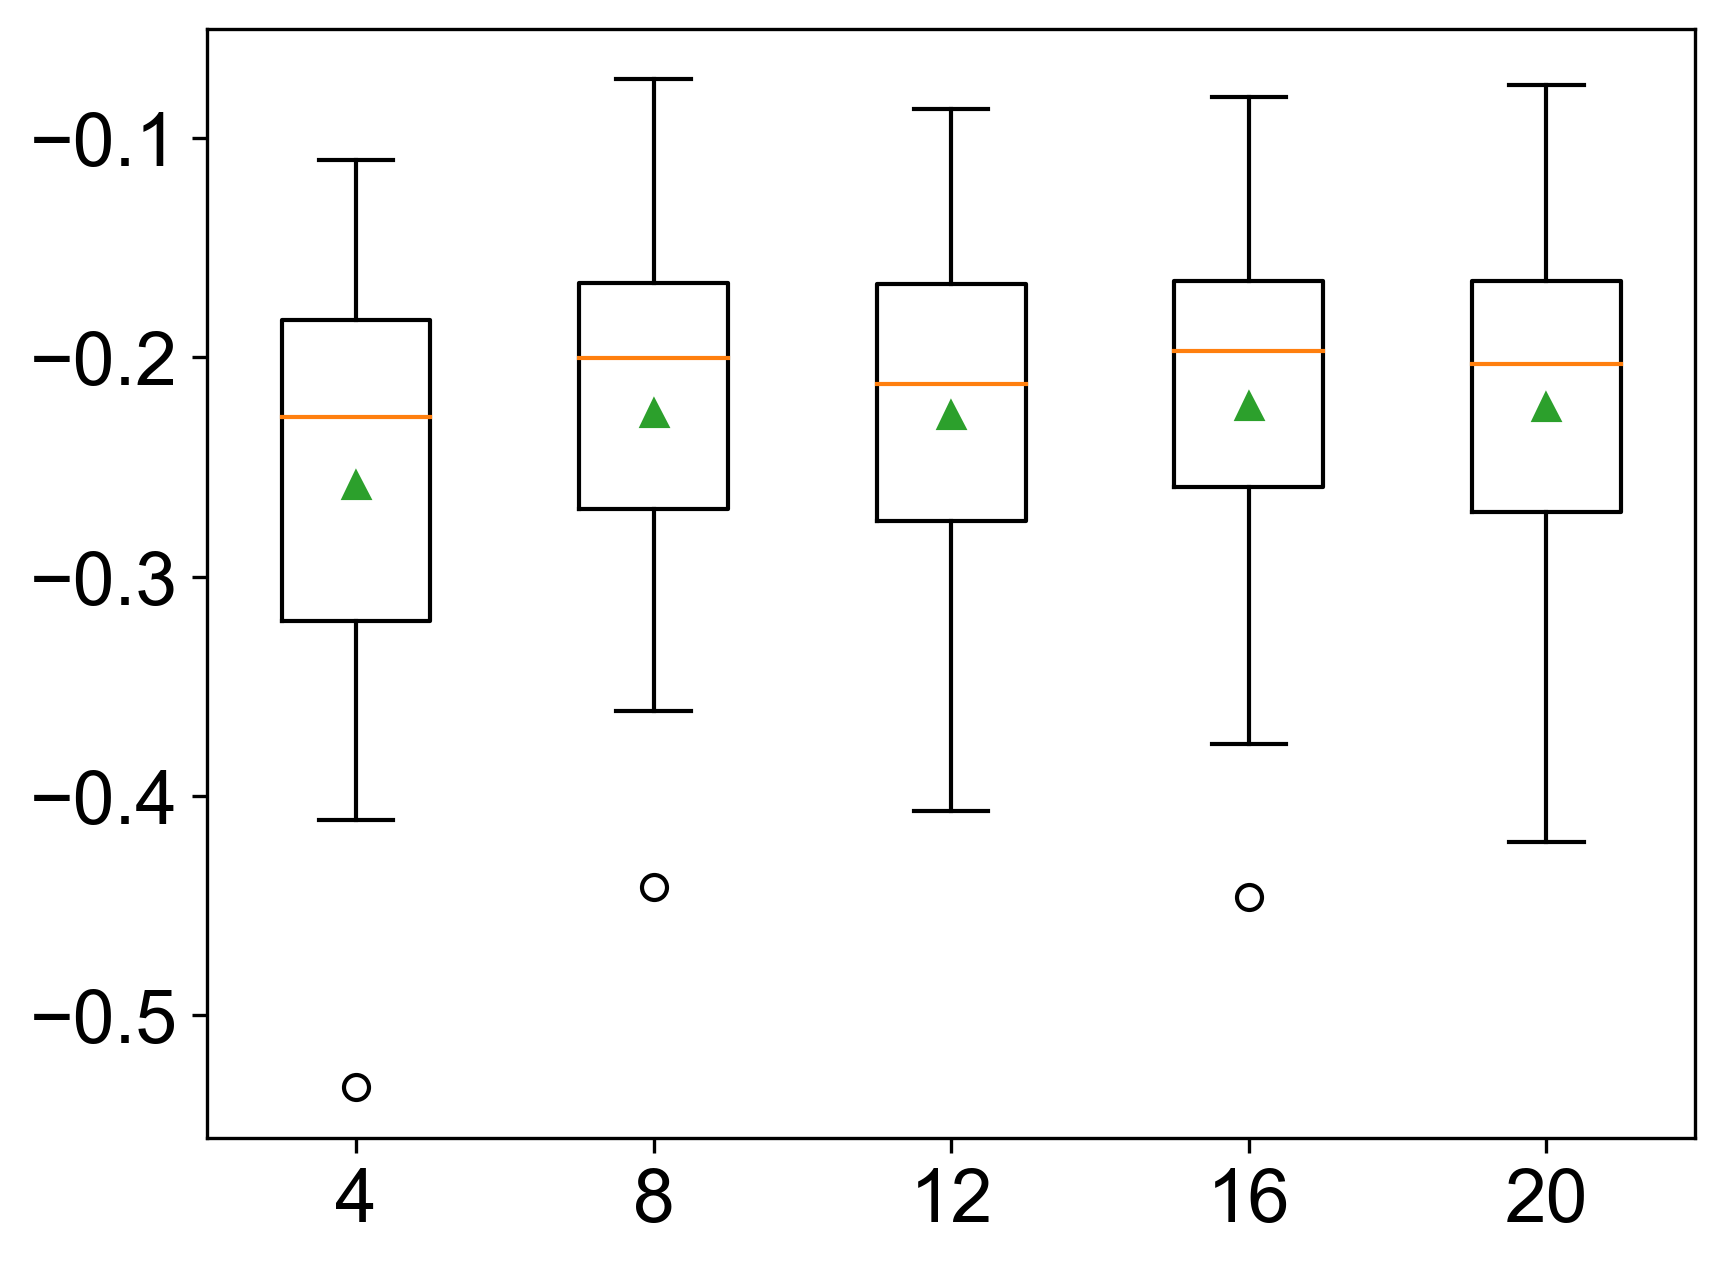

In [145]:
# Get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(4,21,4): # Can change the range of the RFE number of features to be evaluated
        rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=i)
#         model = RandomForestClassifier()
        model = RandomForestRegressor()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# Evaluate any model using cross-validation
def evaluate_model(model, X, y):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # for classification
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) # for regression
    
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# Get the models to evaluate
models = get_models()

# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_all_pre_noCorr, y_binary)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# Plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

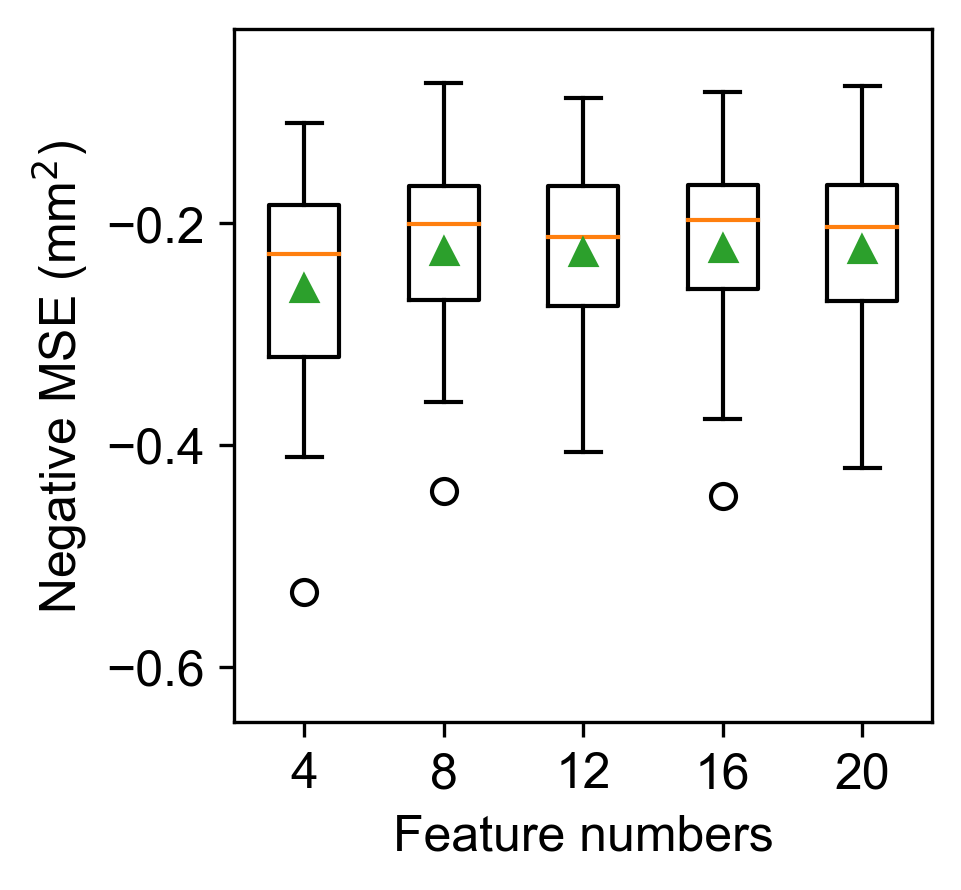

In [160]:
# Editing the figure with the labels

plt.figure(figsize=(3,3))
plt.boxplot(results, labels=names, showmeans=True)
font = {'family' : 'Arial',
#         'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Feature numbers')
plt.ylim([-0.65,-0.025])
plt.ylabel('Negative MSE (mm$^2$)')
plt.show()

In [147]:
# Generating the dataframe with different feature numbers results
featureNum = [4,8,12,16,20]
resultDF = pd.DataFrame(results)
resultDF['featureNum'] = featureNum

# Rearranging columns
cols = resultDF.columns.tolist()
cols = cols[-1:] + cols[:-1]
resultDF = resultDF[cols]

# Saving results as csv
# resultDF.to_csv('20211013_corrDrop_feature4to20_round2_dataset_top10per.csv',index=False)

resultDF

,featureNum,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,4,-0.164631,-0.223947,-0.173082,-0.207660,-0.394275,-0.332000,-0.532821,-0.265312,-0.174319,...,-0.260732,-0.401501,-0.110040,-0.229801,-0.319788,-0.333989,-0.205023,-0.308376,-0.186756,-0.216260
1,8,-0.167803,-0.217408,-0.131660,-0.198901,-0.347127,-0.225409,-0.441284,-0.208813,-0.142863,...,-0.238826,-0.361073,-0.073417,-0.190784,-0.260567,-0.344470,-0.177859,-0.255295,-0.200503,-0.165713
2,12,-0.174636,-0.217635,-0.139635,-0.203756,-0.321396,-0.219860,-0.406716,-0.213101,-0.129545,...,-0.227957,-0.369445,-0.086880,-0.175930,-0.264026,-0.339724,-0.160708,-0.271876,-0.211408,-0.164164
3,16,-0.185670,-0.224362,-0.140883,-0.183606,-0.327538,-0.232688,-0.445867,-0.193383,-0.123046,...,-0.211830,-0.368923,-0.081299,-0.192631,-0.264726,-0.376469,-0.173050,-0.228863,-0.197575,-0.162520
4,20,-0.167768,-0.211760,-0.126746,-0.189294,-0.311295,-0.264687,-0.420929,-0.219065,-0.135335,...,-0.236438,-0.348160,-0.075817,-0.183555,-0.260772,-0.352009,-0.177159,-0.254345,-0.201749,-0.161186


In [22]:
# Based on the results, select the number of features which is the optimum
# In our case, n=8 is the optimum feature number
n = 8

# Now, we go through RFE
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=n)
model = RandomForestRegressor()
pipe = Pipeline([('Feature Selection', rfe), ('Model', model)])

# We also do cross-validation
# In this case, we are using regression because we are training on continuous values
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1) # cross-validation for regression 
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=2) # cross-validation for classification

# Now, we look at the cross-validation score
n_scores = cross_val_score(pipe, X_all_pre_noCorr, y_binary, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
np.mean(n_scores)

-0.2244429406141747

In [23]:
pipe.fit(X_all_pre_noCorr, y_binary) # Fitting to the pipeline

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=RandomForestRegressor(),
                     n_features_to_select=8)),
                ('Model', RandomForestRegressor())])

In [24]:
# Check which one is used and which one is dropped
pd.set_option('display.max_rows', None)
(pd.DataFrame(rfe.support_,index=X_all_pre_noCorr.columns,columns=['Rank']))#.head(20)

,Rank
Reagent1 (ul),True
Reagent2 (ul),True
Reagent3 (ul),True
Reagent4 (ul),True
Reagent5 (ul),False
Reagent6 (ul),False
Reagent7 (ul),False
Reagent8 (ul),False
Reagent9 (ul),False
lab_code,True


## Supervised learning: random forest regression

After we select the features and eliminate the rest of them, now we can start doing the supervised learning: random forest regression.

In [25]:
# Selected features
X_all_pre_noCorr_RFE = X_all_pre_noCorr.loc[:, rfe.support_]

# Save to csv
# X_all_pre_noCorr_RFE.to_csv('20211013_X_all_features8_round2_dataset_top10per.csv',index=False)
X_all_pre_noCorr_RFE

,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),lab_code,AATS3i,AATSC8dv,AATSC5Z
0,28,126,4,41,1,159.729755,0.771203,-0.732077
1,100,6,41,52,1,159.729755,0.771203,-0.732077
2,14,88,18,80,1,159.729755,0.771203,-0.732077
3,28,69,83,20,1,159.729755,0.771203,-0.732077
4,50,3,89,58,1,159.729755,0.771203,-0.732077
5,31,18,83,68,1,159.729755,0.771203,-0.732077
6,42,65,22,71,1,159.729755,0.771203,-0.732077
7,42,52,59,47,1,159.729755,0.771203,-0.732077
8,45,16,108,31,1,159.729755,0.771203,-0.732077
9,135,6,47,11,1,159.729755,0.771203,-0.732077


In [26]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all_pre_noCorr_RFE, y_binary, test_size=0.2, random_state=1) # Test set is 20% of the total data, and the random state is set to ensure identical results for each run

print("X_train's shape is", X_train.shape,"; y_train's shape is", y_train.shape)
print("X_test's shape is", X_test.shape,"; y_test's shape is", y_test.shape)

X_train's shape is (211, 8) ; y_train's shape is (211,)
X_test's shape is (53, 8) ; y_test's shape is (53,)


In [27]:
# Because we're doing random forest, we are not standardizing the train and test set
X_train_stand = X_train
X_test_stand = X_test

In [28]:
# Random Forest, choosing best parameters using GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
    
# Perform Grid-Search to find optimum parameter
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(1,10),
            'n_estimators': (5,10,20,30,40,50,60,70,80,90,100,500,1000),
        },
        cv=5, 
        scoring= 'neg_mean_squared_error', 
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],\
                                random_state=False, verbose=False)
    
# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')#'neg_mean_absolute_error')

    return best_params

print('The best parameters: ',rfr_model(X_train,y_train))

The best parameters:  {'max_depth': 6, 'n_estimators': 50}


Change the random forest regressor parameter.

In [29]:
from sklearn.metrics import mean_squared_error

# Because we're doing random forest, we are not standardizing the train and test set
X_train_stand = X_train
X_test_stand = X_test

# Now change this based on the best parameters above.
rf_regressor = RandomForestRegressor(max_depth =6,n_estimators=50,
                                     random_state=1)

# Fit to the training set
rf_regressor.fit(X_train_stand, y_train)

# Perform predictions on both training and test sets
y_train_hat = rf_regressor.predict(X_train_stand)
y_test_hat = rf_regressor.predict(X_test_stand)
y_all_hat = rf_regressor.predict(X_all_pre_noCorr_RFE)

# View accuracy score

# accuracy_score(y_test, y_test_hat) # for classification
mean_squared_error(y_binary, y_all_hat) # for regression

0.09317751342572678

In [30]:
# A simple visulization functions

def prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat):
    from sklearn import metrics
    fontsize = 12
    plt.figure(figsize=(1.5,1.5))
    plt.rcParams['figure.dpi'] = 300
    plt.figure(figsize=(3,3))
    font = {'family' : 'Arial',
#         'weight' : 'bold',
            'size'   : 12}
    plt.rc('font', **font)
    a = plt.scatter(y_train, y_train_hat, s=25,c='#a2c898')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k:', lw=1.5)
    plt.xlabel('Observation (mm)', fontsize=fontsize)
    plt.ylabel('Prediction (mm)', fontsize=fontsize)
    plt.tick_params(direction='out')
#     plt.title(('Train RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_hat))),\
#                'Test RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_hat)))), fontsize=fontsize)
    print(('Train RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_hat))),
               'Test RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_hat)))))
    b = plt.scatter(y_test, y_test_hat, s=25,c='#427883')
#     plt.legend((a,b),('Train','Test'),fontsize=fontsize,handletextpad=0.1,borderpad=0.1,frameon=False)
    plt.tight_layout()
#     plt.show()

('Train RMSE: 2.48e-01', 'Test RMSE: 4.68e-01')


<Figure size 108x108 with 0 Axes>

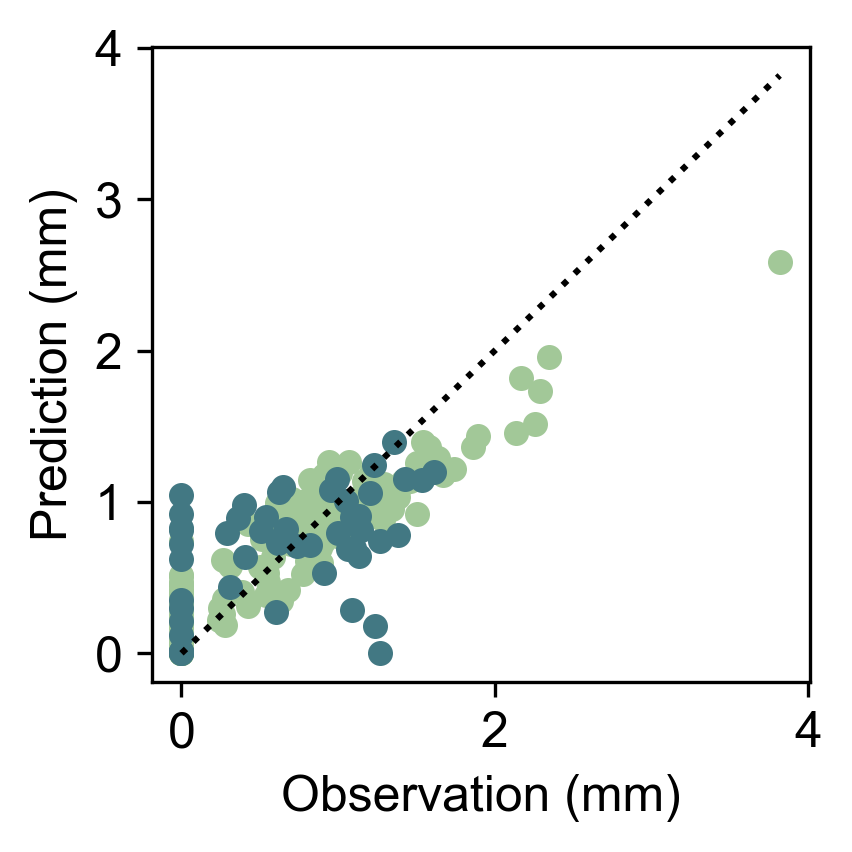

In [31]:
# Visualize the results for regression
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)

## Shapley value analysis

Now, we can do the feature importance rank using Shapley value analysis (https://github.com/slundberg/shap).

In [32]:
import shap

# Use shap to explain our rf_regressor
explainerRF = shap.TreeExplainer(rf_regressor,check_additivity=False)

# Get standardized X Dataframe
X_stand_df = X_all_pre_noCorr_RFE
shap_values_RF_test = explainerRF.shap_values(X_all_pre_noCorr_RFE)

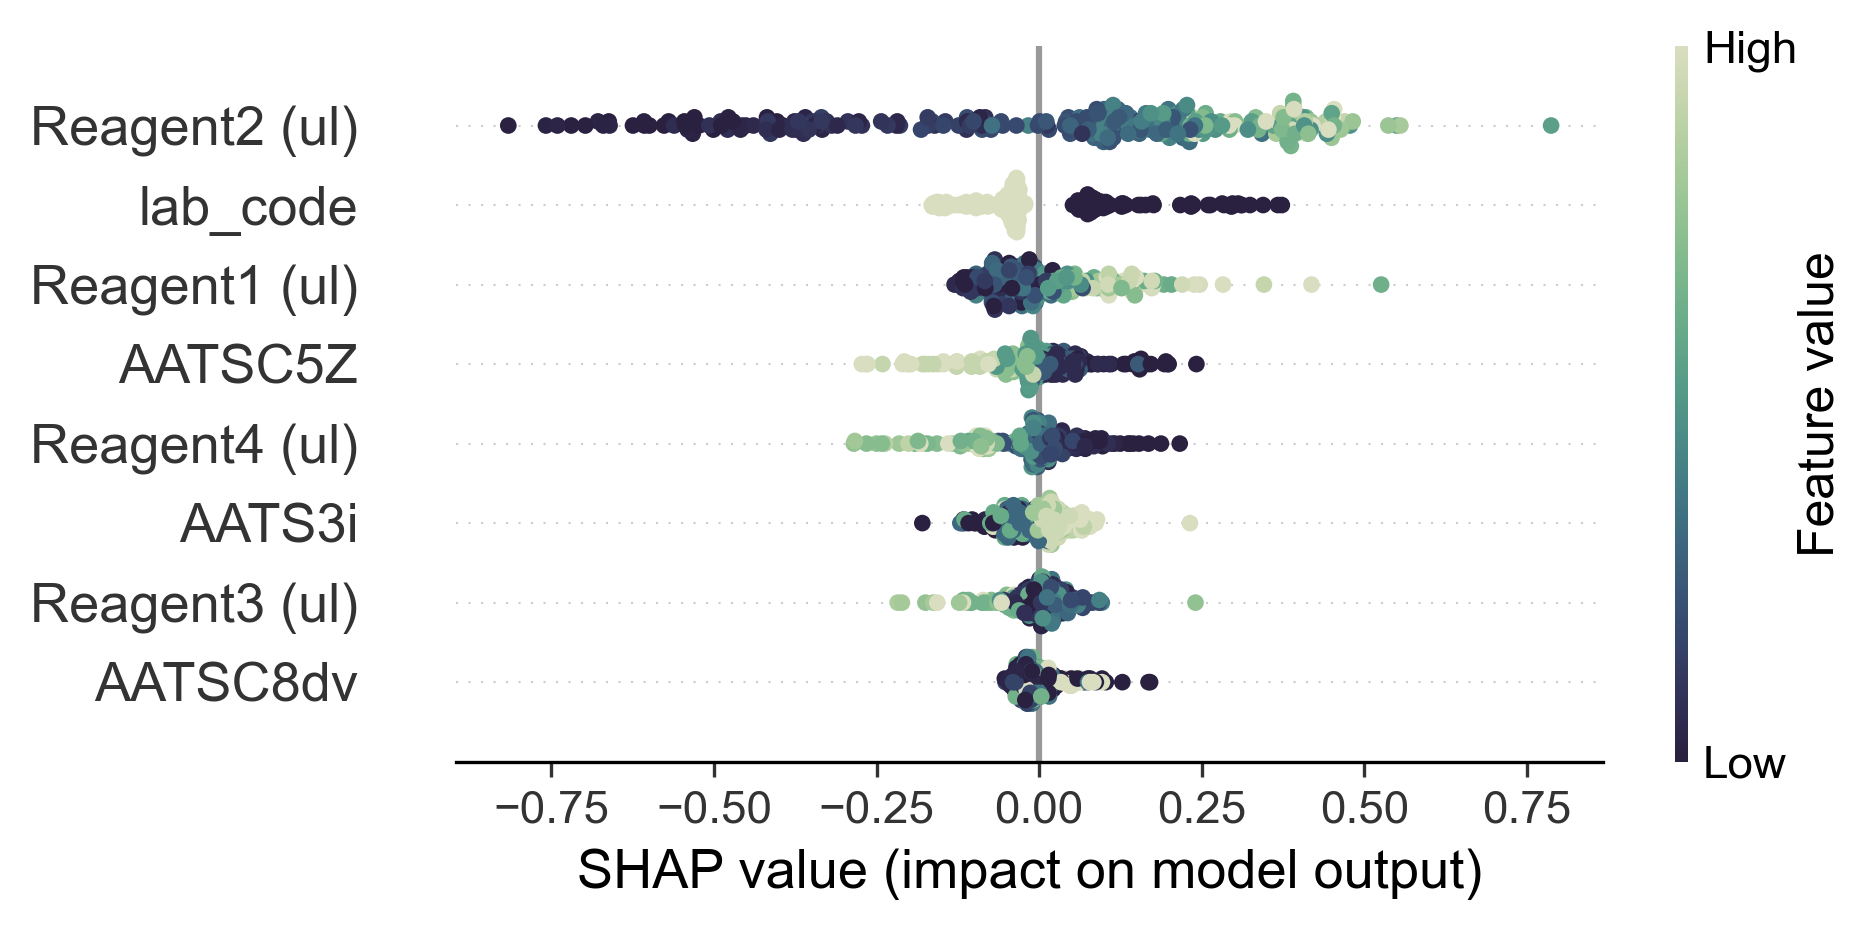

In [33]:
# Plot SHAP figure
plt.figure()
shap.summary_plot(shap_values_RF_test, X_stand_df,plot_type = "dot",
                            #color=plt.get_cmap("plasma"),
                           show = False)
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'font.size': 60})
plt.rcParams['figure.dpi'] = 300

# Change the colormap of the artists, UNCOMMENT FOR DEFAULT COLORMAP
# my_cmap = plt.get_cmap('viridis')
cmap = sns.cubehelix_palette(start=.45, rot=-.75, reverse=True, as_cmap=True)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(cmap)

# plt.show()
plt.tight_layout()

# UNCOMMENT TO SAVE A FIGURE
# plt.savefig('20211007_rf_nonstand_shap_264datapoints_median_4.png', dpi = 1200)

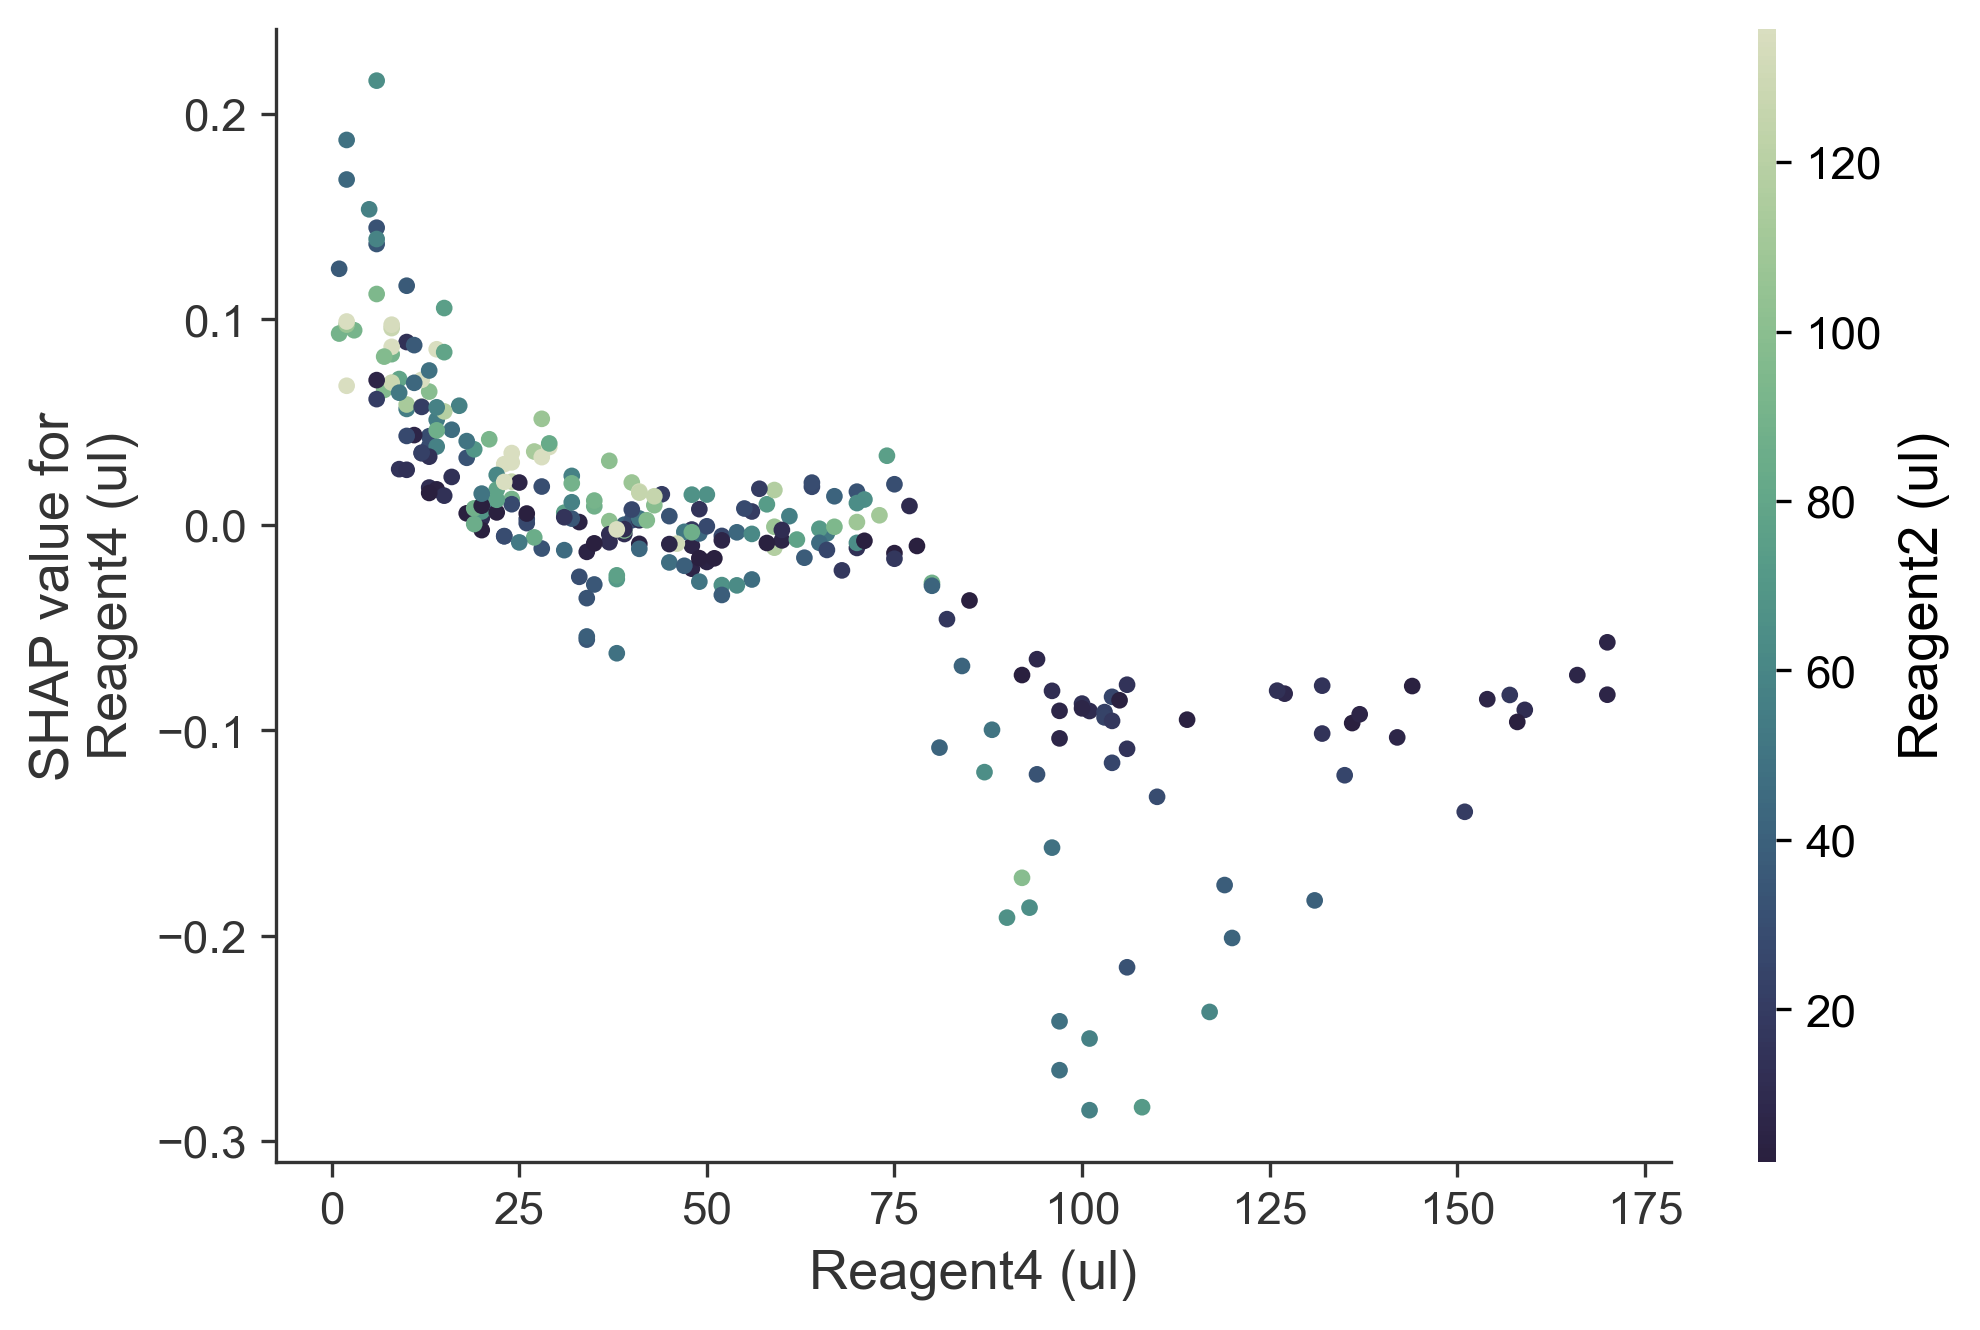

In [34]:
# Plot dependence between two descriptors
shap.dependence_plot("Reagent4 (ul)", shap_values_RF_test, X_all_pre_noCorr_RFE, cmap=cmap)

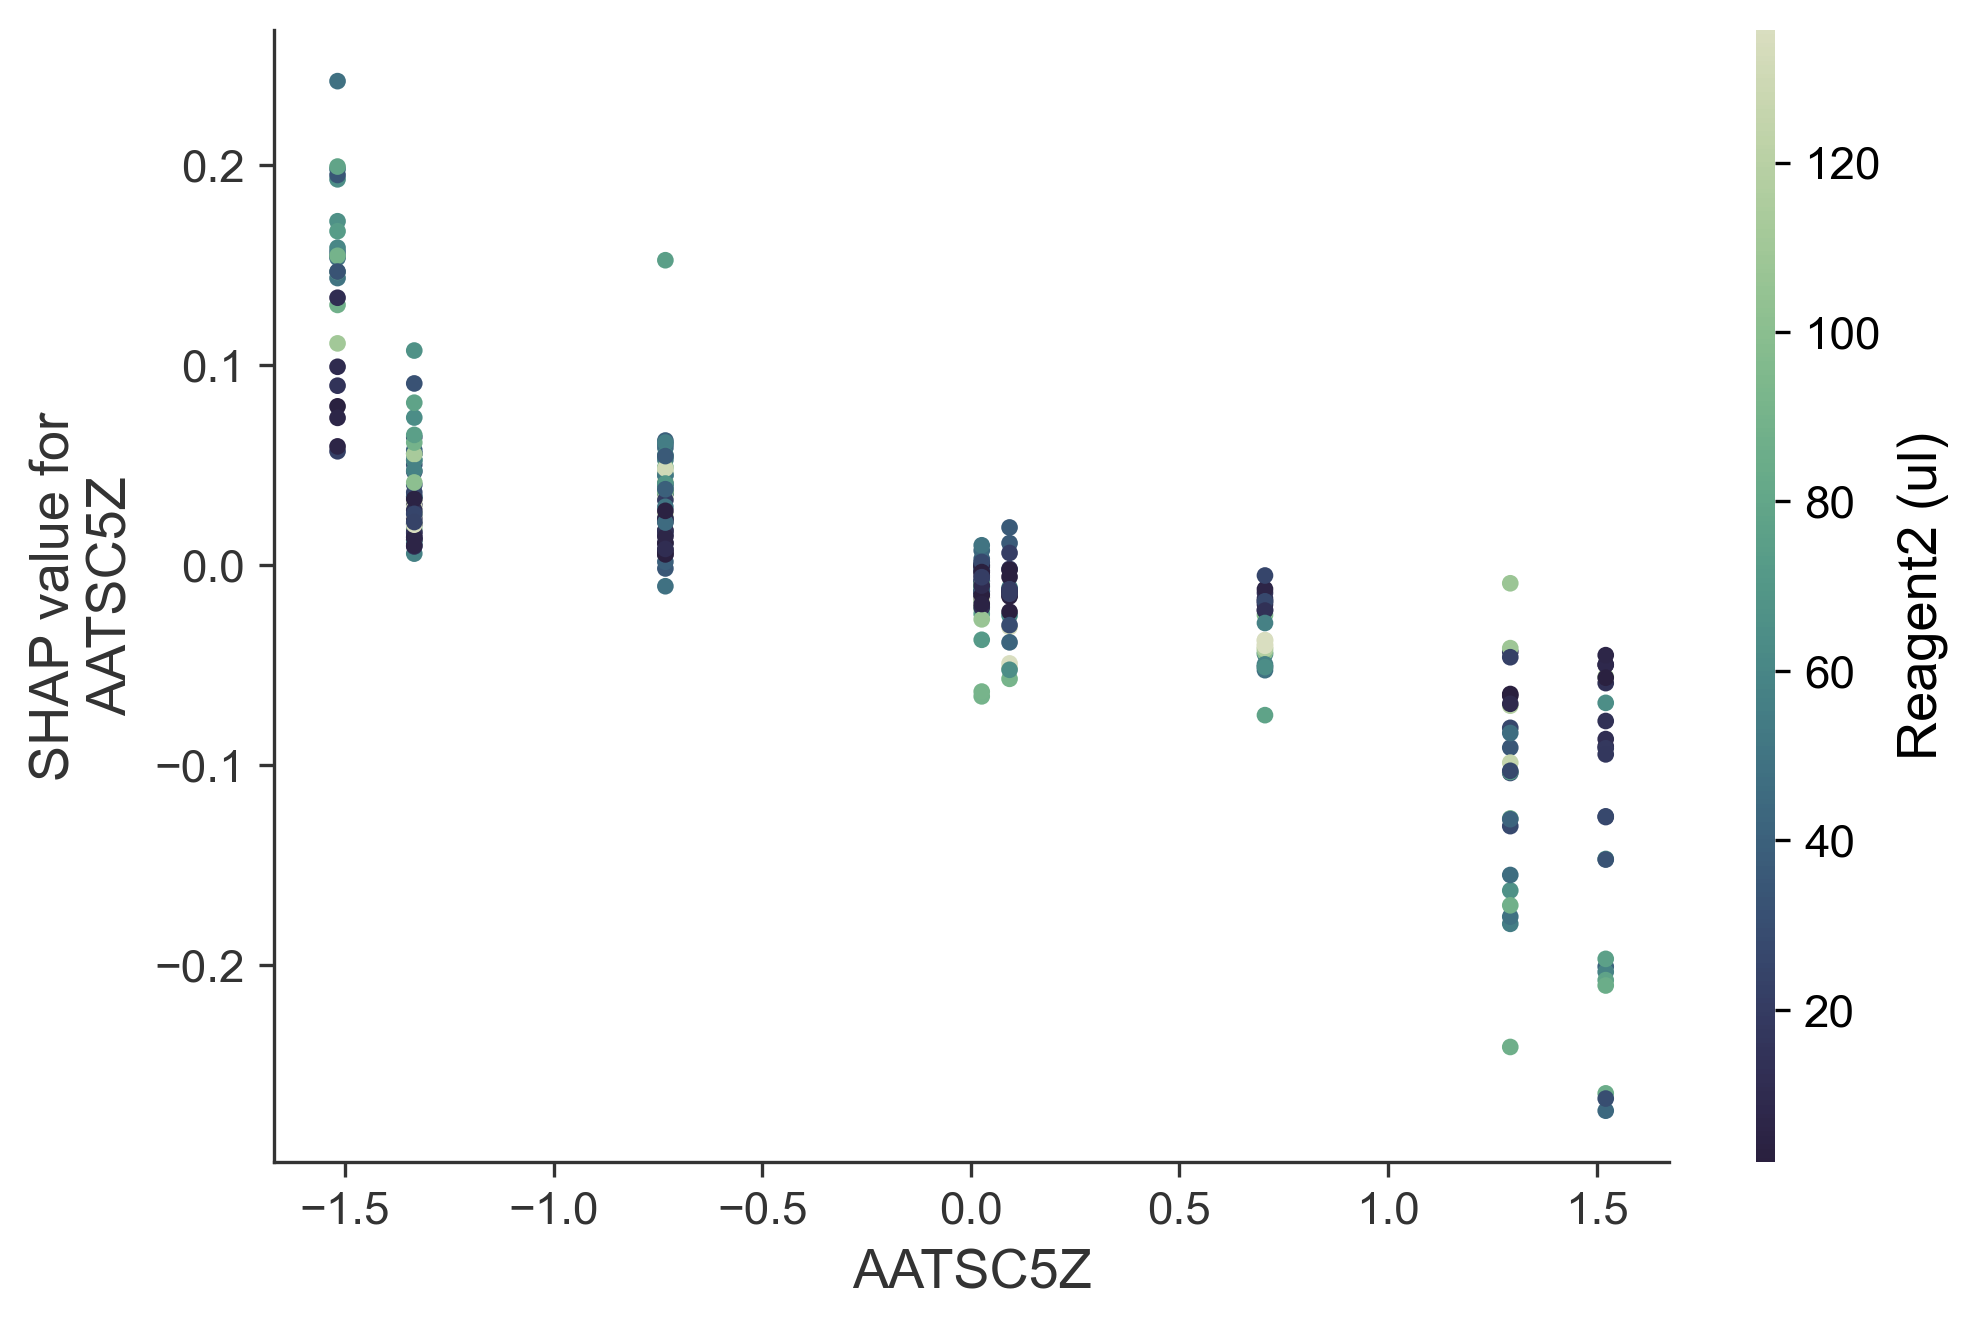

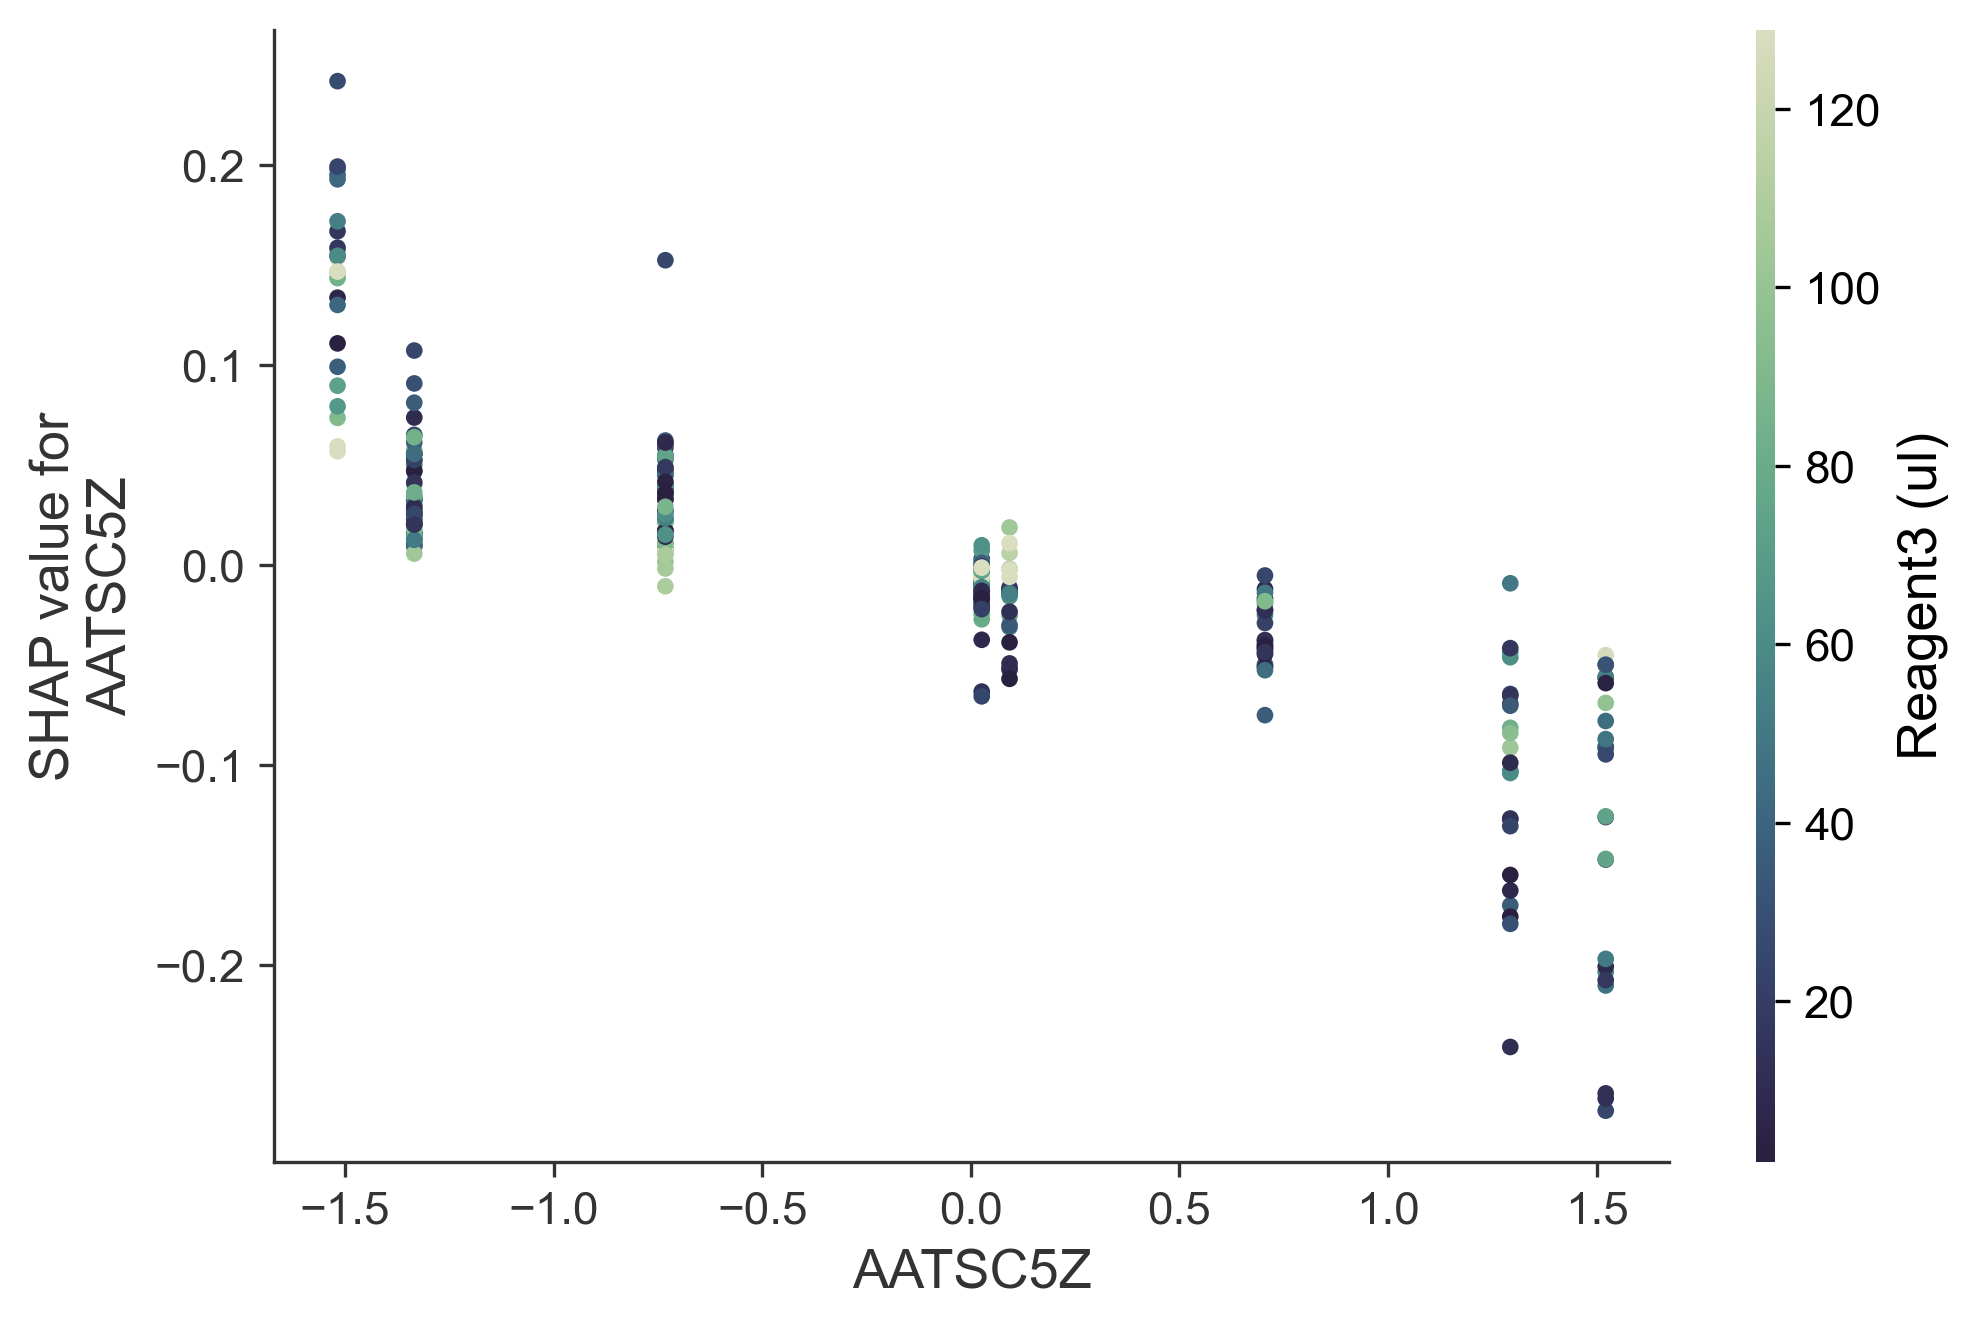

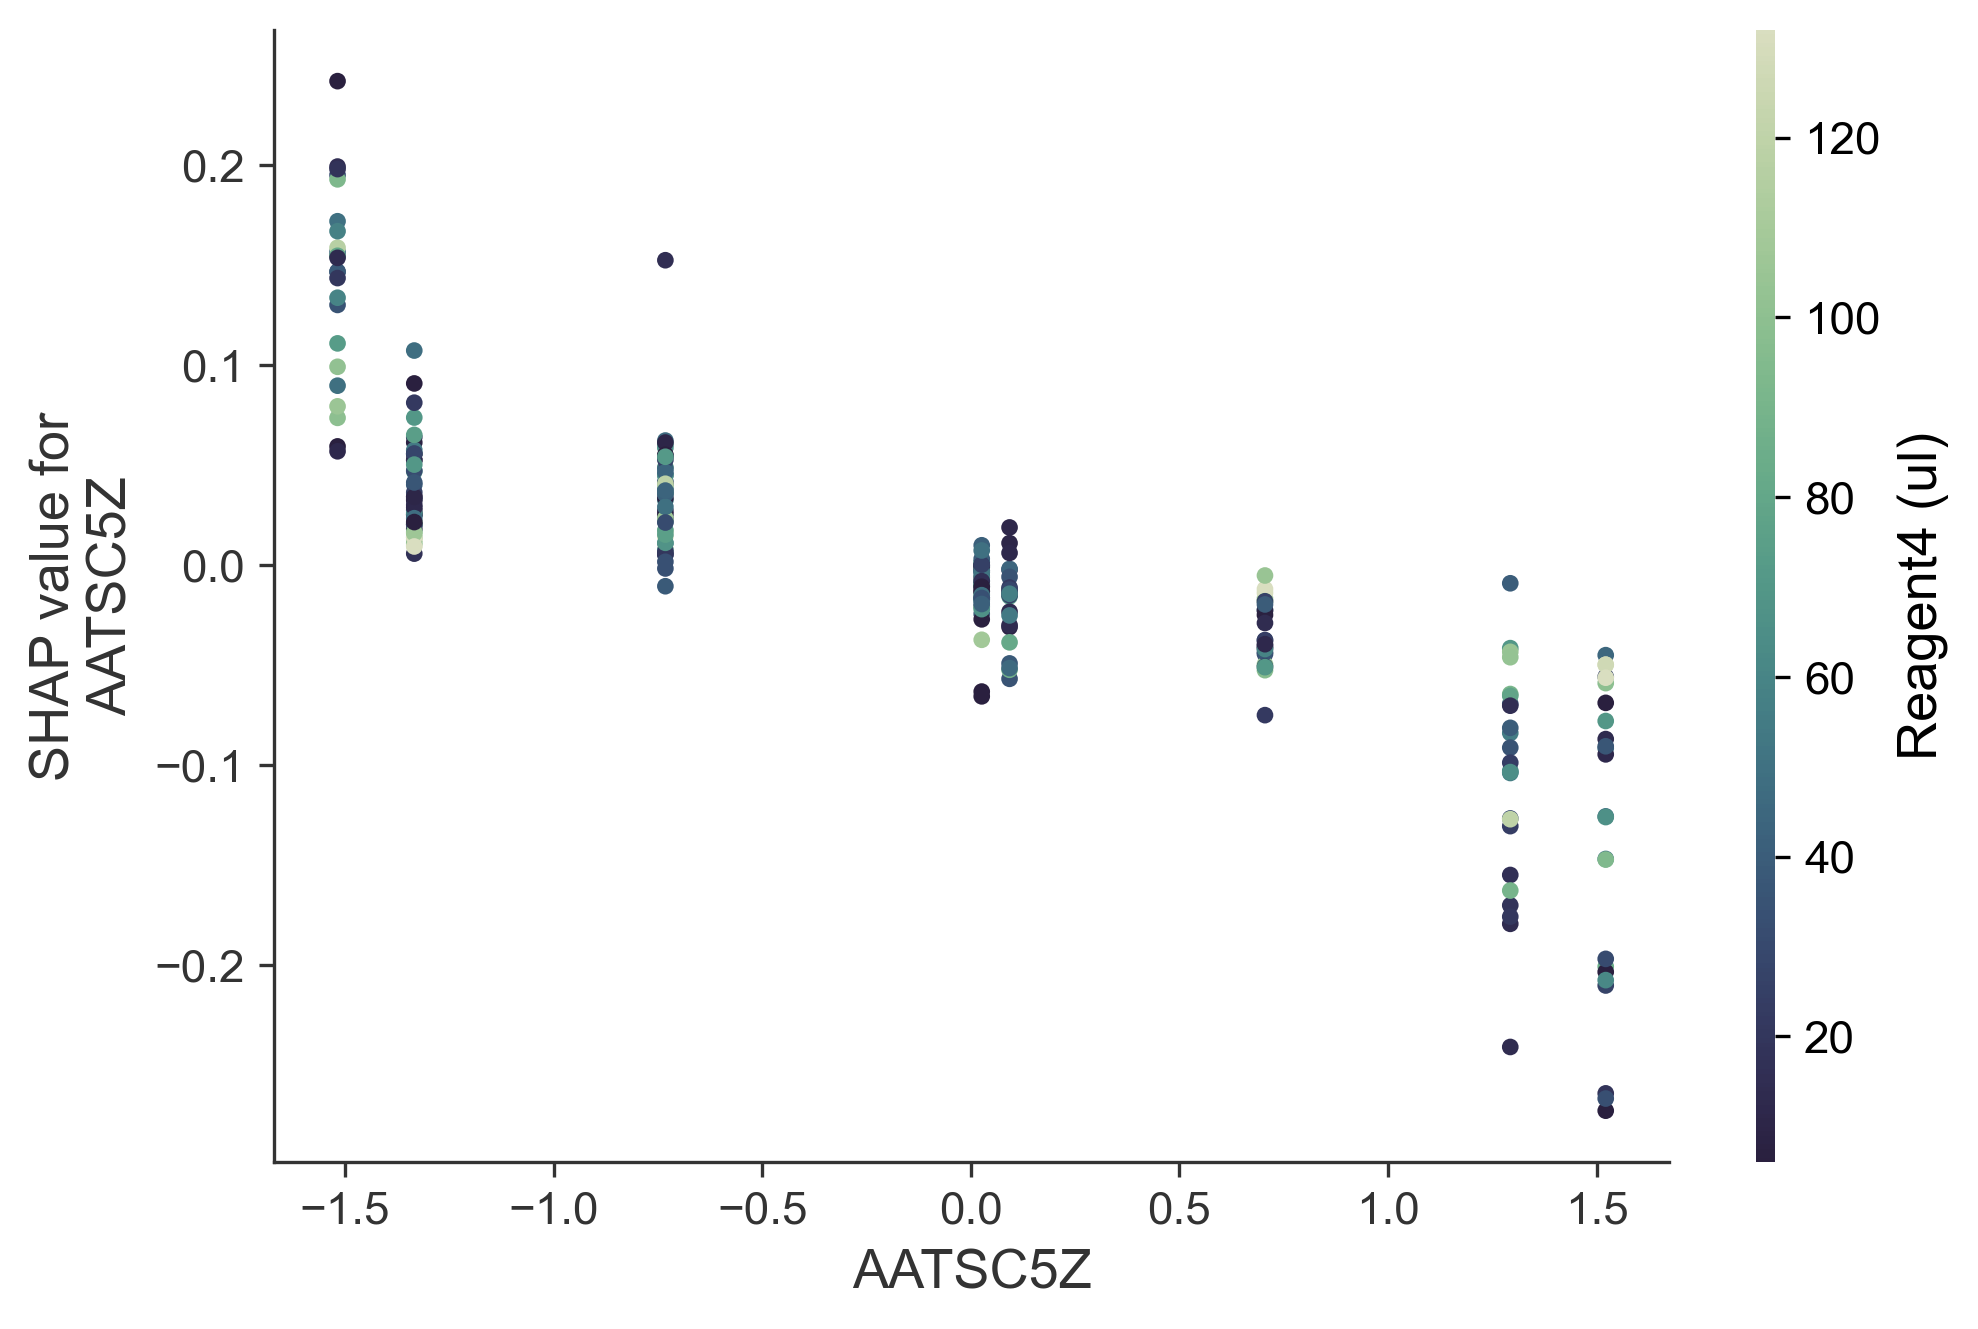

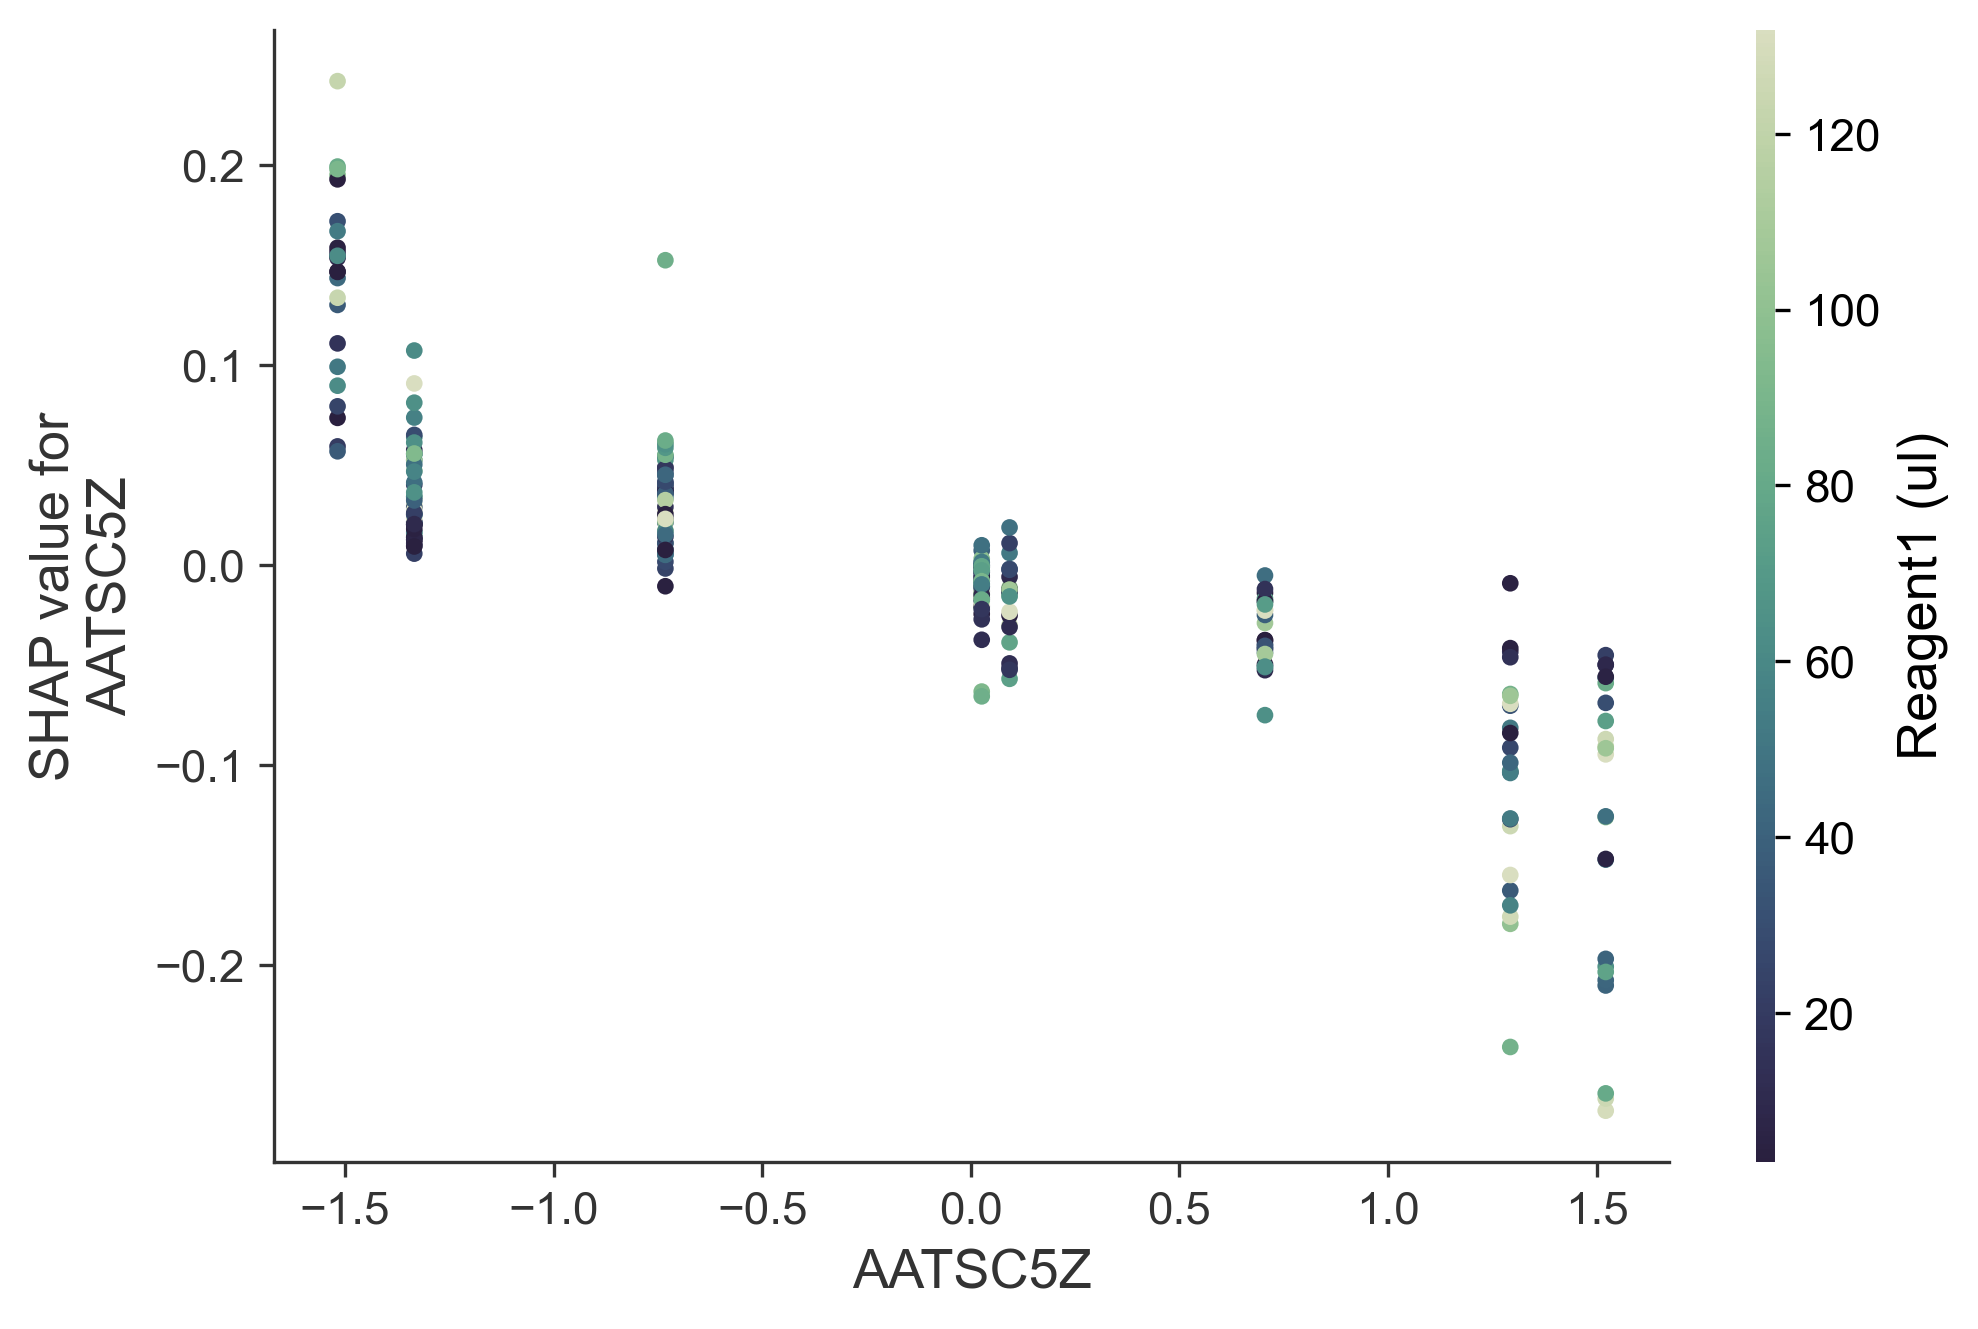

In [36]:
# Plot the possible dependence plots for specific feature of interest

inds = shap.approximate_interactions("AATSC5Z", shap_values_RF_test, X_all_pre_noCorr_RFE)

# make plots colored by each of the top three possible interacting features
for i in range(4):
    shap.dependence_plot("AATSC5Z", shap_values_RF_test, X_all_pre_noCorr_RFE,
                         interaction_index=inds[i],cmap=cmap)